<a href="https://colab.research.google.com/github/Jaderfonseca/youtube-filter-bubbles/blob/main/pipeline_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Filter Bubbles in YouTube Recommendations
**Mini‑project** · Portfolio-ready version

This notebook reproduces the pipeline used to collect a small corpus of YouTube videos by seed queries, build a similarity graph via TF‑IDF, cluster content, and compute simple diversity metrics. It is intentionally compact and reproducible for reviewers.


## How to run
1. Open in Google Colab.
2. Run the **Setup** cell to install packages and securely input your **YouTube Data API v3** key.
3. Execute cells in order: **Data collection → Preprocessing → TF‑IDF & Similarity → Clustering → Metrics → Plots**.
4. Outputs are written to `data/` and figures to `figures/`.


**Folder structure**

- `data/raw/` – raw CSVs from collection
- `data/clean/` – deduplicated & text‑processed CSVs
- `data/processed/` – TF‑IDF, similarity, clustering, metrics
- `figures/` – saved plots


**YouTube Filter Bubbles — Minimal, Reproducible Pipeline**

This notebook loads cleaned CSVs (or optionally collects a small seed set using the YouTube API), builds TF-IDF similarity, constructs a small interpretable graph, and produces four figures:

- `figures/graph_overview.png` (network colored by seed, node size by degree)
- `figures/graph_lcc.png` (largest connected component)
- `figures/jaccard_seeds.png` (Jaccard similarity across seeds)
- `figures/diversity_by_seed.png` (normalized entropy)
- `figures/entropy_vs_step.png` (entropy vs. graph step)

All outputs are written under `data/{raw,clean,processed}` and `figures/`.


In [1]:
!pip install -q google-api-python-client pandas numpy scikit-learn networkx matplotlib python-louvain

import os, json, math, itertools, collections
import numpy as np
import pandas as pd
from pathlib import Path

# folders
for p in ["data/raw","data/clean","data/processed","figures"]:
    os.makedirs(p, exist_ok=True)

# your three seed topics
SEEDS = ["beginner guitar", "healthy cooking", "stretching exercises"]
REGION = "US"
TOPK_PER_SEED = 5          # neighbors per seed when building the small graph
RANDOM_STATE = 42


In [2]:
# Set to True ONLY if you want to recollect data. Otherwise the notebook uses existing CSVs.
USE_API = True

if USE_API:
    from getpass import getpass
    from googleapiclient.discovery import build

    API_KEY = getpass("Paste your YouTube API key (input is hidden): ").strip()
    assert API_KEY, "Empty API_KEY"

    youtube = build("youtube", "v3", developerKey=API_KEY, cache_discovery=False)

    def search_videos_by_query(query, max_results=150, region_code="US"):
        rows, token = [], None
        while len(rows) < max_results:
            params = dict(part="snippet", q=query, type="video", maxResults=50, regionCode=region_code)
            if token: params["pageToken"] = token
            r = youtube.search().list(**params).execute()
            for it in r.get("items", []):
                rows.append({
                    "seed_query": query,
                    "video_id": it["id"]["videoId"],
                    "title": it["snippet"].get("title",""),
                    "description": it["snippet"].get("description",""),
                    "channel_title": it["snippet"].get("channelTitle","")
                })
                if len(rows) >= max_results: break
            token = r.get("nextPageToken")
            if not token: break
        return pd.DataFrame(rows)

    # collect a small seed set per topic
    dfs = [search_videos_by_query(q, max_results=150, region_code=REGION) for q in SEEDS]
    df_seed = pd.concat(dfs, ignore_index=True).drop_duplicates(subset=["video_id"])
    df_seed.to_csv("data/raw/videos_raw.csv", index=False)
    print("Saved: data/raw/videos_raw.csv with", len(df_seed), "rows")


Paste your YouTube API key (input is hidden): ··········
Saved: data/raw/videos_raw.csv with 423 rows


In [3]:
# Load RAW if present, otherwise allow continuing from prior CLEAN
nodes_raw = Path("data/raw/videos_raw.csv")
if nodes_raw.exists():
    df_videos = pd.read_csv(nodes_raw)
else:
    clean_nodes = Path("data/clean/videos_clean.csv")
    assert clean_nodes.exists(), "No raw or clean nodes available. Enable USE_API once to create data."
    df_videos = pd.read_csv(clean_nodes)

# drop duplicates; drop fully-empty columns
df_videos = df_videos.drop_duplicates(subset=["video_id"]).copy()
df_videos = df_videos.dropna(axis=1, how="all")

# single text field for TF-IDF
df_videos["text"] = (df_videos["title"].fillna("") + " " + df_videos["description"].fillna("")).str.strip()

# save CLEAN nodes
df_videos.to_csv("data/clean/videos_clean.csv", index=False)

print("Saved CLEAN nodes:", "data/clean/videos_clean.csv")
print("Rows:", len(df_videos))
print("Duplicates by video_id:", df_videos.duplicated(subset=["video_id"]).sum())


Saved CLEAN nodes: data/clean/videos_clean.csv
Rows: 423
Duplicates by video_id: 0


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X = vectorizer.fit_transform(df_videos["text"].astype(str))
np.save("data/processed/tfidf_shape.npy", np.array(X.shape))

# JSON-serializable vocabulary (keys as strings, values as ints)
with open("data/processed/tfidf_vocabulary.json","w") as f:
    vocab = {str(k): int(v) for k, v in vectorizer.vocabulary_.items()}
    json.dump(vocab, f)

# cosine similarity (dense OK at this scale)
S = cosine_similarity(X)              # N x N
np.save("data/processed/similarity_matrix.npy", S)

# id -> row index
id2idx = {vid:i for i,vid in enumerate(df_videos["video_id"])}

# representative seed per video_id
seed_per_video = (
    df_videos.groupby("video_id")["seed_query"]
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else "unknown")
      .to_dict()
)

# k nearest neighbors excluding self
def topk_neighbors(idx, k=TOPK_PER_SEED):
    sims = S[idx].copy()
    sims[idx] = -1.0
    top = np.argsort(-sims)[:k]
    return list(zip(top, sims[top]))

# build edges by taking k-NN for each video that has one of the target seeds
rows = []
valid_seed = set(SEEDS)
for vid, seed in seed_per_video.items():
    if seed not in valid_seed:
        continue
    i = id2idx.get(vid)
    if i is None:
        continue
    for j, sim in topk_neighbors(i, k=TOPK_PER_SEED):
        rows.append({
            "seed_query": seed,
            "source_video_id": df_videos.loc[i, "video_id"],
            "video_id":        df_videos.loc[j, "video_id"],
            "title":           df_videos.loc[j, "title"],
            "channel_title":   df_videos.loc[j, "channel_title"],
            "similarity":      float(sim)
        })

df_edges = pd.DataFrame(rows).drop_duplicates()
# keep edges whose endpoints exist in nodes
valid_ids = set(df_videos["video_id"])
df_edges = df_edges[
    df_edges["source_video_id"].isin(valid_ids) & df_edges["video_id"].isin(valid_ids)
].copy()

# save both processed and clean versions
df_edges.to_csv("data/processed/similarity_topk_edges.csv", index=False)
df_edges.to_csv("data/clean/edges_clean.csv", index=False)

print("Saved edges:", "data/clean/edges_clean.csv", "rows:", len(df_edges))


Saved edges: data/clean/edges_clean.csv rows: 2115


In [5]:
import os
import pandas as pd

VIDEOS_PATH = "data/clean/videos_clean.csv"
EDGES_PATH  = "data/clean/edges_clean.csv"

assert os.path.exists(VIDEOS_PATH), f"Missing file: {VIDEOS_PATH}."
assert os.path.exists(EDGES_PATH),  f"Missing file: {EDGES_PATH}."

df_videos = pd.read_csv(VIDEOS_PATH)
df_edges  = pd.read_csv(EDGES_PATH)

print(f"Loaded (CLEAN): {len(df_videos)} videos; {len(df_edges)} edges")
display(df_videos.head(2)); display(df_edges.head(2))

# minimal integrity checks (keep visible)
print("Duplicates by video_id:", df_videos.duplicated(subset=["video_id"]).sum())
print("Unique source nodes in edges:", df_edges["source_video_id"].nunique())
print("Unique target nodes in edges:", df_edges["video_id"].nunique())


Loaded (CLEAN): 423 videos; 2115 edges


,seed_query,video_id,title,description,channel_title,text
0,beginner guitar,d52MZJw-hIE,Learn First 3 Chords on Guitar in 3 Minutes! |...,If you ever thought about learning guitar but ...,Acoustic Selection,Learn First 3 Chords on Guitar in 3 Minutes! |...
1,beginner guitar,BBz-Jyr23M4,Guitar Lesson 1 - Absolute Beginner? Start Her...,https://www.andyguitar.co.uk/courses/starter-c...,Andy Guitar,Guitar Lesson 1 - Absolute Beginner? Start Her...


,seed_query,source_video_id,video_id,title,channel_title,similarity
0,healthy cooking,-4PZHHCUJZc,n3_3TxHXfPU,How To EAT HEALTHY on a LOW BUDGET,Adam Frater,0.298735
1,healthy cooking,-4PZHHCUJZc,dDLRaiocb_k,Healthy Meals That Don&#39;t Suck,KWOOWK,0.266983


Duplicates by video_id: 0
Unique source nodes in edges: 423
Unique target nodes in edges: 420


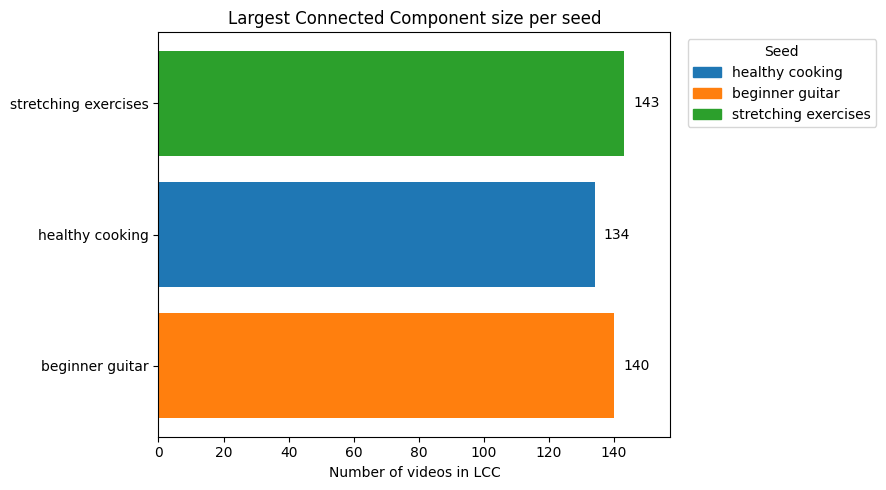

Saved figure to: figures/lcc_sizes.png
LCC sizes: {'beginner guitar': 140, 'healthy cooking': 134, 'stretching exercises': 143}


In [10]:
# Largest Connected Component size per seed (with soft tab10 colors)

import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 1) Load CLEAN data (assumes your pipeline already saved these files)
VIDEOS_PATH = "data/clean/videos_clean.csv"
EDGES_PATH  = "data/clean/edges_clean.csv"
df_videos = pd.read_csv(VIDEOS_PATH)
df_edges  = pd.read_csv(EDGES_PATH)

# 2) Build an undirected graph (canonicalize edges so (u,v)==(v,u))
edges_uv = df_edges[["source_video_id", "video_id"]].dropna().astype(str)
edges_uv = edges_uv.rename(columns={"source_video_id": "u", "video_id": "v"})
canon_uv = np.minimum(edges_uv[["u","v"]].to_numpy(), edges_uv[["v","u"]].to_numpy())
canon_vu = np.maximum(edges_uv[["u","v"]].to_numpy(), edges_uv[["v","u"]].to_numpy())
canon = pd.DataFrame(np.column_stack([canon_uv[:,0], canon_vu[:,1]]), columns=["u","v"]).drop_duplicates()
G = nx.from_pandas_edgelist(canon, source="u", target="v", create_using=nx.Graph())

# 3) Compute LCC size for each seed (within its own induced subgraph)
lcc_sizes = {}
for seed in df_videos["seed_query"].dropna().unique():
    nodes_seed = set(df_videos.loc[df_videos["seed_query"] == seed, "video_id"].astype(str))
    H = G.subgraph(nodes_seed).copy()
    if H.number_of_nodes() == 0:
        lcc_sizes[seed] = 0
    else:
        comps = sorted(nx.connected_components(H), key=len, reverse=True)
        lcc_sizes[seed] = len(comps[0])

# 4) Plot with soft tab10 colors (consistent with your other charts)
palette = {
    "healthy cooking":   "#1f77b4",  # soft blue
    "beginner guitar":   "#ff7f0e",  # soft orange
    "stretching exercises": "#2ca02c",  # soft green
}
seeds_order = list(lcc_sizes.keys())
values = [lcc_sizes[s] for s in seeds_order]
colors = [palette.get(s, "#1f77b4") for s in seeds_order]

plt.figure(figsize=(9,5))
bars = plt.barh(seeds_order, values, color=colors)

# annotate values to the right of bars
xmax = max(values) if values else 0
for bar, val in zip(bars, values):
    plt.text(val + max(2, 0.02*xmax), bar.get_y() + bar.get_height()/2,
             f"{val}", va="center", ha="left")

plt.xlabel("Number of videos in LCC")
plt.title("Largest Connected Component size per seed")


plt.legend(
    handles=legend_handles,
    title="Seed",
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)


# add a bit of right margin to prevent clipping
plt.xlim(0, xmax + max(10, 0.1*xmax))
os.makedirs("figures", exist_ok=True)
plt.tight_layout()
plt.savefig("figures/lcc_sizes.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved figure to: figures/lcc_sizes.png")
print("LCC sizes:", lcc_sizes)


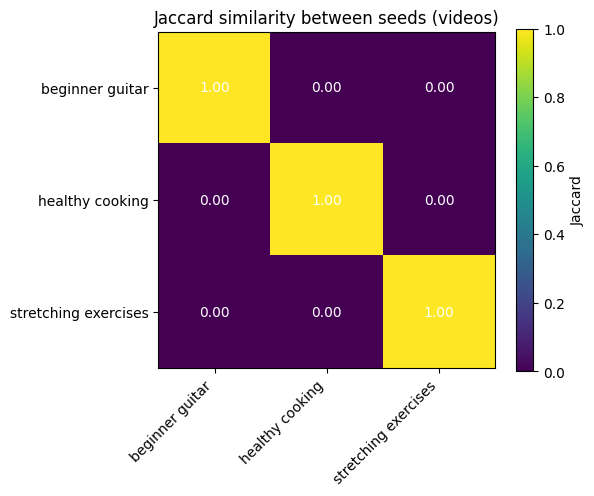

Saved: figures/jaccard_seeds.png


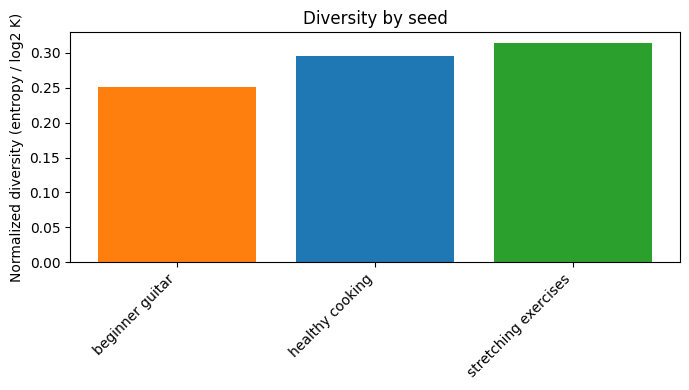

Saved: figures/diversity_by_seed.png


In [11]:
# === Similarity & Diversity summaries ===
# Requires: df_videos (with columns ['video_id','seed_query']), df_edges (['source_video_id','video_id'])
# Also assumes SEEDS is defined as the list of your three seeds in desired order.
import math, collections, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs("figures", exist_ok=True)

# ---------- Jaccard similarity between seeds (videos) ----------
# sets of video_ids by seed
by_seed = {s: set(df_videos.loc[df_videos["seed_query"] == s, "video_id"]) for s in SEEDS}

def jaccard(a, b):
    inter = len(a & b)
    uni = len(a | b) or 1
    return inter / uni

J = np.zeros((len(SEEDS), len(SEEDS)), dtype=float)
for i, si in enumerate(SEEDS):
    for j, sj in enumerate(SEEDS):
        J[i, j] = jaccard(by_seed[si], by_seed[sj])

plt.figure(figsize=(6, 5))
plt.imshow(J, vmin=0, vmax=1, cmap="viridis")
plt.colorbar(label="Jaccard")
plt.xticks(range(len(SEEDS)), SEEDS, rotation=45, ha="right")
plt.yticks(range(len(SEEDS)), SEEDS)
for i in range(len(SEEDS)):
    for j in range(len(SEEDS)):
        plt.text(j, i, f"{J[i,j]:.2f}", ha="center", va="center", color="w")
plt.title("Jaccard similarity between seeds (videos)")
plt.tight_layout()
plt.savefig("figures/jaccard_seeds.png", dpi=150)
plt.show()
print("Saved: figures/jaccard_seeds.png")

# ---------- Diversity by seed (entropy of neighbor seeds reached via edges) ----------
# Map each video_id -> its (most frequent) seed label
# If there are duplicates in df_videos for a video_id, use the mode of seed_query.
seed_per_video = (
    df_videos.groupby("video_id")["seed_query"]
    .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else "unknown")
    .to_dict()
)

# Build, for each seed S, the multiset of neighbor seeds reached from source videos with seed S
neighbors_by_seed = {s: [] for s in SEEDS}
if {"source_video_id", "video_id"}.issubset(df_edges.columns):
    # keep only edges whose endpoints we can map to seeds
    has_src = df_edges["source_video_id"].isin(seed_per_video)
    has_dst = df_edges["video_id"].isin(seed_per_video)
    e2 = df_edges.loc[has_src & has_dst, ["source_video_id", "video_id"]].copy()

    # For each edge, look at the seed of its source and the seed of its target
    src_seeds = e2["source_video_id"].map(seed_per_video)
    dst_seeds = e2["video_id"].map(seed_per_video)

    for s_src, s_dst in zip(src_seeds, dst_seeds):
        if s_src in neighbors_by_seed:
            neighbors_by_seed[s_src].append(s_dst)

def entropy_normalized(labels_list, universe_size):
    """Shannon entropy of the label distribution, normalized by log2(universe_size)."""
    cnt = collections.Counter(labels_list)
    tot = sum(cnt.values())
    if tot == 0:
        return 0.0
    ps = [c / tot for c in cnt.values() if c > 0]
    H = -sum(p * math.log(p, 2) for p in ps)
    norm = math.log(max(1, universe_size), 2)
    return H / norm if norm > 0 else 0.0

K = len(SEEDS)  # normalize by the number of seed categories
diversity = {s: entropy_normalized(neighbors_by_seed[s], K) for s in SEEDS}

# Use the same soft Tab10-inspired palette you picked elsewhere
palette = {
    "healthy cooking":    "#1f77b4",  # soft blue
    "beginner guitar":    "#ff7f0e",  # soft orange
    "stretching exercises":"#2ca02c", # soft green
}
colors = [palette.get(s, "#1f77b4") for s in SEEDS]

plt.figure(figsize=(7, 4))
plt.bar(range(len(SEEDS)), [diversity[s] for s in SEEDS], color=colors)
plt.xticks(range(len(SEEDS)), SEEDS, rotation=45, ha="right")
plt.ylabel("Normalized diversity (entropy / log2 K)")
plt.title("Diversity by seed")
plt.tight_layout()
plt.savefig("figures/diversity_by_seed.png", dpi=150)
plt.show()
print("Saved: figures/diversity_by_seed.png")


Seed 'beginner guitar': 145 videos in table, 145 present in graph
Seed 'healthy cooking': 134 videos in table, 134 present in graph
Seed 'stretching exercises': 144 videos in table, 144 present in graph


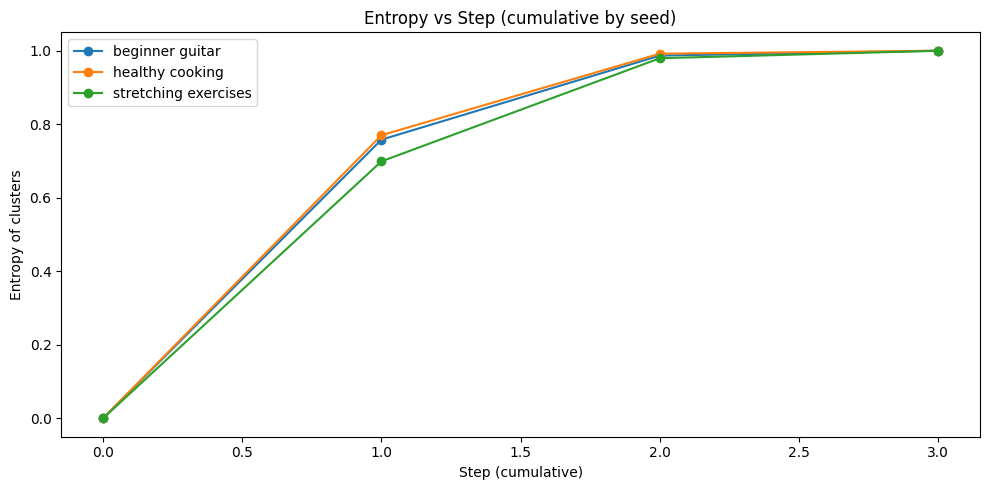

Saved: figures/entropy_vs_step.png


In [12]:
# --- Helpers (idempotent if re-run) ---

from collections import Counter
import math

# Map node -> seed label (unknown if missing)
seed_by_node = dict(zip(df_videos["video_id"], df_videos["seed_query"]))

def normalized_entropy_of_seeds(node_ids):
    """Shannon entropy of seed labels over node_ids, normalized by log2(K)."""
    labels = [seed_by_node.get(n, "unknown") for n in node_ids]
    labels = [x for x in labels if x is not None]  # drop Nones
    if len(labels) == 0:
        return 0.0
    c = Counter(labels)
    ps = [v/len(labels) for v in c.values()]
    H = -sum(p*math.log(p, 2) for p in ps if p > 0)
    K = max(1, len(SEEDS))  # number of expected seeds
    return H / math.log(K, 2)

def nodes_within_k(G, starts, k):
    """Union of nodes within <=k hops from ANY start node (cumulative)."""
    visited = set(starts)
    frontier = set(starts)
    for _ in range(k):
        nxt = set()
        for u in frontier:
            nxt.update(G.neighbors(u))
        nxt -= visited
        visited |= nxt
        frontier = nxt
        if not frontier:
            break
    return visited

# --- Build series per seed with debug guards ---

steps = [0, 1, 2, 3]  # the x-axis you expect

# Start nodes present in the graph for each seed
by_seed_ids = {s: set(df_videos.loc[df_videos["seed_query"] == s, "video_id"]) for s in SEEDS}
seed_nodes = {s: sorted([vid for vid in by_seed_ids[s] if vid in G]) for s in SEEDS}

# Quick sanity print (kept visible for grading transparency)
for s in SEEDS:
    print(f"Seed '{s}': {len(by_seed_ids[s])} videos in table, {len(seed_nodes[s])} present in graph")

series = {s: [] for s in SEEDS}
for s in SEEDS:
    starts = seed_nodes[s]
    if len(starts) == 0:
        # nothing to expand from; fill zeros so the plot still renders
        series[s] = [0.0 for _ in steps]
        continue

    # step 0: only the seeds' own nodes
    series[s].append(normalized_entropy_of_seeds(starts))

    # cumulative expansion
    for k in steps[1:]:
        nodes_k = nodes_within_k(G, starts, k)
        series[s].append(normalized_entropy_of_seeds(nodes_k))

# --- Plot ---

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for s in SEEDS:
    plt.plot(steps, series[s], marker="o", label=s)

plt.xlabel("Step (cumulative)")
plt.ylabel("Entropy of clusters")
plt.title("Entropy vs Step (cumulative by seed)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/entropy_vs_step.png", dpi=150)
plt.show()
print("Saved: figures/entropy_vs_step.png")


## Finished

Artifacts:
- CLEAN nodes: `data/clean/videos_clean.csv`
- CLEAN edges: `data/clean/edges_clean.csv`
- TF-IDF & similarity: `data/processed/*`
- Figures: `figures/*.png`

Repro tips:
- To rebuild from scratch, set `USE_API=True` and rerun from the top.
- To keep runs deterministic, do not change `TOPK_PER_SEED` and `RANDOM_STATE`.
